# Tugas Akhir 4 - Modeling
Kelompok 1 :
- Daffa Tama Ramadani
- Erdiansyah
- Ainun

Pada modul kali ini kita akan melakukan modeling untuk forecasting jumlah tamu hotel

Note : Sebelumnya sudah dilakukan modeling menggunakan data dengan grup Tahun, namun hasil prediksinya sangat buruk jadi kita melakukan data preparation ulang dengan data grup bulan

## Import library yang dibutuhkan

In [1]:
# Import library yang dibutuhkan

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import AutoRegresion
from statsmodels.tsa.ar_model import AutoReg

# import auto_arima
from pmdarima import auto_arima

# import ARIMA
from statsmodels.tsa.arima.model import ARIMA

# import adfuller untuk cek stationary data
from statsmodels.tsa.stattools import adfuller

# import plot_acf dan plot_pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

## Tentang Dataset Tamu DKI Jakarta

Dataset tamu DKI Jakarta ini merupakan dataset hasil slicing dari proses Data Preparation. Dataset ini berisi jumlah tamu hotel bintang DKI Jakarta dari tahun 2008-2021 (perbulan)

Untuk pemodelan kali ini kita akan menggunakan model statistika Auto Regression dan ARIMA, hal ini di dasarkan karna jumlah point data yang tidak terlalu banyak jadi kami menyimpulkan bahwa penggunaan metode machine learning akan kurang cocok. Karna untuk menggunakan metode machine learning kita harus slicing data kami menjadi data feature dan data target, hal ini akan memangkas dataset kami yang sejak awal sudah sedikit

## Membaca Dataset

In [2]:
jakartadf = pd.read_csv('data/JakartaHotel.csv', index_col=['dt'], parse_dates=True)

Setalah dataset telah di load ke dataframe selanjutnya kita akan melihat sample dari data dengan fungsi head()

In [3]:
jakartadf.head()

,value
dt,
2008-01-01,52290
2008-02-01,50980
2008-03-01,52030
2008-04-01,56410
2008-05-01,55200


Ploting dataset

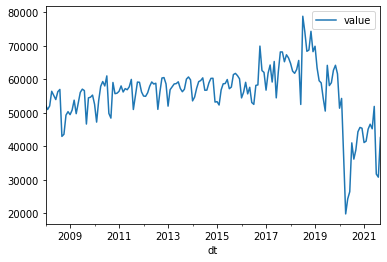

In [4]:
jakartadf.plot()
plt.show()

## Stationary Test

Untuk melakukan forecasting data timeseries, data timeseries haruslah stationer (rata-rata dan variannya konstan). untuk mengecek apakah data kita sudah stationer kita akan melakukan Dickey Fuller Test

In [5]:
#Dickey Fuller Test

dftest = adfuller(jakartadf['value'], autolag='AIC')

print('1.  ADF : ',dftest[0])
print('2.  P-Value : ',dftest[1])
print('3.  Num of Lags : ',dftest[2])
print('4.  Num of Oservation User for ADF Regression and Critical Values Calculation : ',dftest[3])
print('5.  Critical Values : ')
for key, val in dftest[4].items():
    print('\t', key, '\t: ', val)

1.  ADF :  -1.5481977279899668
2.  P-Value :  0.5095483289063039
3.  Num of Lags :  12
4.  Num of Oservation User for ADF Regression and Critical Values Calculation :  152
5.  Critical Values : 
	 1% 	:  -3.474120870218417
	 5% 	:  -2.880749791423677
	 10% 	:  -2.5770126333102494


Terlihat bahwa nilai P-Value terlalu besar (P-Value > .05), maka bisa disimpulkan bahwa data tidak stationary. untuk melakukan timeseries forecasting kita harus membuat data tersebut menjadi stationary. untuk kitu kita akan melakukan shiting data dengan fungsi diff()

In [6]:
# cek jumlah diff yang dibutuhkan untuk membuat data stationary

from pmdarima.arima.utils import ndiffs
ndiffs(jakartadf.value, test='adf')

1

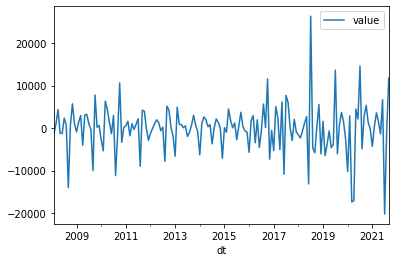

In [7]:
# membuat data stationary dengan diff()

jak_stat = jakartadf.diff().dropna()
jak_stat.plot()
plt.show()

Cek ulang data stationary

In [8]:
# Dickey Fuller Test

dftest = adfuller(jak_stat['value'], autolag='AIC')

print('1.  ADF : ',dftest[0])
print('2.  P-Value : ',dftest[1])
print('3.  Num of Lags : ',dftest[2])
print('4.  Num of Oservation User for ADF Regression and Critical Values Calculation : ',dftest[3])
print('5.  Critical Values : ')
for key, val in dftest[4].items():
    print('\t', key, '\t: ', val)

1.  ADF :  -3.8645985218898184
2.  P-Value :  0.0023113940031922395
3.  Num of Lags :  11
4.  Num of Oservation User for ADF Regression and Critical Values Calculation :  152
5.  Critical Values : 
	 1% 	:  -3.474120870218417
	 5% 	:  -2.880749791423677
	 10% 	:  -2.5770126333102494


Dari hasil test terlihat bahwa kini data menjadi stationary (P-Value < .05)

## Auto Regression Model

Mengambil value dari data

In [9]:
X = jak_stat
X.shape

(164, 1)

Split dataset menjadi variabel train dan test

In [10]:
train = X.iloc[:len(X)-34]
test = X.iloc[len(X)-34:]

Membuat model Auto Regression model

In [11]:
ar_model = AutoReg(train, lags=12).fit()

In [12]:
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  value   No. Observations:                  130
Model:                    AutoReg(12)   Log Likelihood               -1117.777
Method:               Conditional MLE   S.D. of innovations           3145.563
Date:                Sat, 11 Dec 2021   AIC                           2263.554
Time:                        23:13:31   BIC                           2302.344
Sample:                    02-01-2009   HQIC                          2279.304
                         - 11-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        879.6853    320.727      2.743      0.006     251.072    1508.298
value.L1      -0.7692      0.090     -8.555      0.000      -0.945      -0.593
value.L2      -0.6591      0.114     -5.777      0.0

Melakukan prediksi dengan test set

In [13]:
ar_pred = ar_model.predict(start=len(train), end=len(X)-1, dynamic=False)
ar_pred

2018-12-01    -4825.711933
2019-01-01    -2379.967688
2019-02-01     1061.387523
2019-03-01    -2322.910879
2019-04-01     2012.445557
2019-05-01    -3375.245838
2019-06-01     -496.986081
2019-07-01    14877.577344
2019-08-01    -8389.333604
2019-09-01    -2082.635985
2019-10-01     3056.394187
2019-11-01     2490.843661
2019-12-01    -4614.312182
2020-01-01      477.701365
2020-02-01     1159.236528
2020-03-01    -2360.914032
2020-04-01     1152.248041
2020-05-01    -2909.112604
2020-06-01     4445.681915
2020-07-01     5627.093489
2020-08-01    -7387.722350
2020-09-01     1172.933285
2020-10-01     2948.603493
2020-11-01      -19.363040
2020-12-01    -3094.531354
2021-01-01     2174.362655
2021-02-01     -151.944622
2021-03-01    -1825.980927
2021-04-01      680.671581
2021-05-01     -901.149419
2021-06-01     4529.555211
2021-07-01      158.984781
2021-08-01    -4387.287113
2021-09-01     2640.093950
Freq: MS, dtype: float64

Ploting hasil prediksi

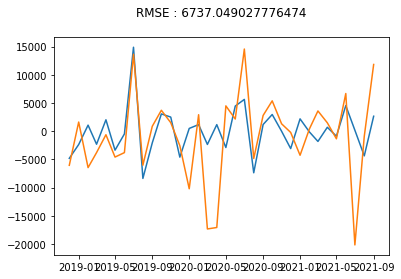

In [14]:
plt.plot(ar_pred, label='Prediksi')
plt.plot(test, label='Asli')
ar_rmse = sqrt(mean_squared_error(test, ar_pred))
plt.title('RMSE : {0}\n'.format(ar_rmse))
plt.show()

## ARIMA model

Split dataset menjadi variabel train dan test

In [15]:
train = jak_stat.iloc[:-34]
test = jak_stat.iloc[-34:]

Untuk modeling menggunakan ARIMA, kita memerlukan 3 variabel order yaitu :
- p, didapatkan dari Partial Autocorrelation (ACF)
- d, different
- q, didapatkan dari Autocorrelation (ACF)

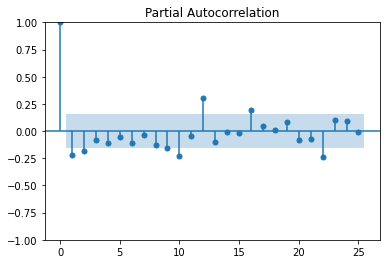

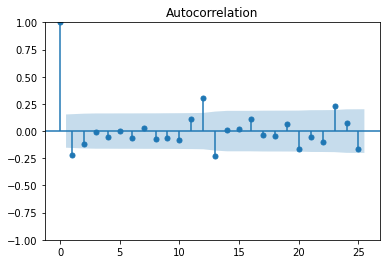

In [16]:
pacf = plot_pacf(jak_stat['value'], lags=25)
acf = plot_acf(jak_stat['value'], lags=25)
plt.show()

Membuat ARIMA model

In [17]:
arima_model = ARIMA(train['value'], order=(12,1,2))
arima_model = arima_model.fit()

In [18]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  130
Model:                ARIMA(12, 1, 2)   Log Likelihood               -1230.311
Date:                Sat, 11 Dec 2021   AIC                           2490.623
Time:                        23:13:36   BIC                           2533.520
Sample:                    02-01-2008   HQIC                          2508.053
                         - 11-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1276      0.549     -2.054      0.040      -2.204      -0.052
ar.L2         -0.9959      0.518     -1.923      0.055      -2.011       0.019
ar.L3         -0.9173      0.523     -1.755      0.079      -1.942       0.107
ar.L4         -0.8222      0.490     -1.676      0.094      -1.784       0.139
ar.L5         -0.7954      0.447     -1.778      0.075      -1.672       0.081
ar.L6         -0.7930      0.453     -1.749      0.080      -1.682       0.096
ar.L7         -0.7373      0.445     -1.655      0.098      -1.610       0.136
ar.L8         -0.7720      0.412     -1.874      0.061      -1.580       0.036
ar.L9         -0.8010      0.440     -1.820      0.069      -1.664       0.062
ar.L10        -0.8361      0.466     -1.793      0.073      -1.750       0.078
ar.L11        -0.5302      0.488     -1.086      0.278      -1.488       0.427
ar.L12         0.0915      0.329      0.278      0.781      -0.554       0.737
ma.L1         -0.5526      0.586     -0.943      0.346      -1.701       0.595
ma.L2         -0.3599      0.524     -0.687      0.492      -1.386       0.667
sigma2      1.216e+07   3.48e-07    3.5e+13      0.000    1.22e+07    1.22e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                41.78
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                             0.39
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.69e+28. Standard errors may be unstable.
"""

Melakukan prediksi dengan test set

In [19]:
arima_pred = arima_model.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
arima_pred

2018-12-01    -3576.218794
2019-01-01    -2850.421974
2019-02-01      516.870563
2019-03-01     -935.010299
2019-04-01      906.103561
2019-05-01    -3558.412340
2019-06-01      729.314665
2019-07-01    15358.176549
2019-08-01    -9373.594701
2019-09-01      -56.418465
2019-10-01     2569.866326
2019-11-01     2900.016071
2019-12-01    -4338.905934
2020-01-01     -198.435162
2020-02-01     1100.266478
2020-03-01    -1466.823287
2020-04-01     -599.926848
2020-05-01    -2352.805846
2020-06-01     6074.336593
2020-07-01     4957.405107
2020-08-01    -7396.603703
2020-09-01     3532.447267
2020-10-01     2005.278811
2020-11-01      489.825045
2020-12-01    -3206.215844
2021-01-01     1879.832220
2021-02-01       52.105484
2021-03-01    -1776.445208
2021-04-01     -767.025263
2021-05-01      441.302984
2021-06-01     5373.809568
2021-07-01     -964.708236
2021-08-01    -3095.212731
2021-09-01     4207.469309
Freq: MS, Name: predicted_mean, dtype: float64

Ploting hasil prediksi

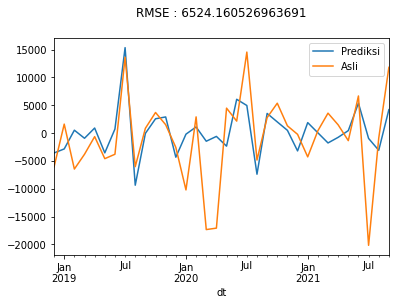

In [20]:
arima_pred.plot(legend=True, label='Prediksi')
test['value'].plot(legend=True, label='Asli')
arima_rmse = sqrt(mean_squared_error(arima_pred, test['value']))
plt.title('RMSE : {0}\n'.format(arima_rmse))
plt.show()

## Bandingkan Hasil

Setelah mendapatkan hasil prediksi dari kedua model, kita akan membandingkan hasilnya

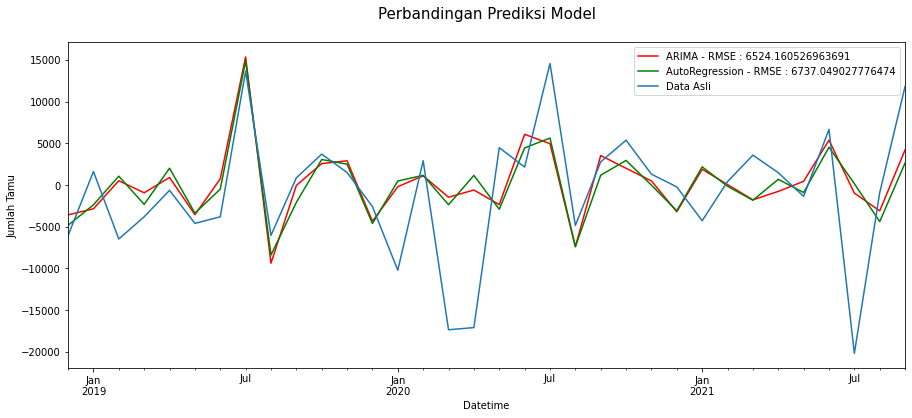

In [21]:
ar_rmse = sqrt(mean_squared_error(ar_pred, test['value']))
arima_rmse = sqrt(mean_squared_error(arima_pred, test['value']))
plt.figure(figsize=(15,6))
arima_pred.plot(legend=True, color='red', label='ARIMA - RMSE : {0}'.format(arima_rmse))
ar_pred.plot(legend=True, color='green', label='AutoRegression - RMSE : {0}'.format(ar_rmse))
test['value'].plot(legend=True, label='Data Asli')
plt.title('Perbandingan Prediksi Model\n', size=15)
plt.xlabel('Datetime')
plt.ylabel('Jumlah Tamu')
plt.show()

In [22]:
# deskripsi statistik Auto regression
ar_pred.describe()

count       34.000000
mean       -25.273385
std       4202.275298
min      -8389.333604
25%      -2375.204274
50%         69.810871
75%       2133.883380
max      14877.577344
dtype: float64

In [23]:
# deskripsi statistik ARIMA
arima_pred.describe()

count       34.000000
mean       193.565940
std       4297.443792
min      -9373.594701
25%      -2208.715686
50%         -2.156491
75%       1973.917164
max      15358.176549
Name: predicted_mean, dtype: float64

## Actual Forecasting

Setelah didapatkan hasil dari model Auto Regression dan ARIMA, selanjutnya kita akan melakukan forecasting untuk data nyatanya. Melihat hasil forecasting ARIMA memiliki nilai RMSE yang lebih baik dari Auto Regression, maka kita akan menggunakan model ARIMA.

In [24]:
model = ARIMA(jak_stat['value'], order=(12,1,2))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  164
Model:                ARIMA(12, 1, 2)   Log Likelihood               -1614.002
Date:                Sat, 11 Dec 2021   AIC                           3258.004
Time:                        23:13:40   BIC                           3304.410
Sample:                    02-01-2008   HQIC                          3276.845
                         - 09-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5715      0.250     -2.290      0.022      -1.061      -0.082
ar.L2         -0.3118      0.137     -2.281      0.023      -0.580      -0.044
ar.L3         -0.1935      0.140     -1.384      0.166      -0.467       0.080
ar.L4         -0.1852      0.137     -1.349      0.177      -0.454       0.084
ar.L5         -0.1508      0.164     -0.917      0.359      -0.473       0.171
ar.L6         -0.1671      0.182     -0.919      0.358      -0.523       0.189
ar.L7         -0.1431      0.172     -0.832      0.405      -0.480       0.194
ar.L8         -0.1859      0.160     -1.164      0.244      -0.499       0.127
ar.L9         -0.2183      0.141     -1.548      0.122      -0.495       0.058
ar.L10        -0.2043      0.142     -1.434      0.152      -0.483       0.075
ar.L11         0.0325      0.134      0.242      0.809      -0.231       0.296
ar.L12         0.3232      0.077      4.179      0.000       0.172       0.475
ma.L1         -0.7332      0.265     -2.762      0.006      -1.254      -0.213
ma.L2         -0.2467      0.252     -0.980      0.327      -0.740       0.247
sigma2      2.534e+07   3.26e-08   7.78e+14      0.000    2.53e+07    2.53e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               254.74
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               4.44   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.69e+30. Standard errors may be unstable.
"""

In [25]:
# membuat prediksi untuk 50 bulan kedepan
pred = model.predict(start=len(jak_stat), end=len(jak_stat)+50, typ='levels')
pred

2021-10-01    -700.547805
2021-11-01    -454.808152
2021-12-01   -1493.851947
2022-01-01   -1297.244820
2022-02-01    1062.882924
2022-03-01    1585.509732
2022-04-01     807.582093
2022-05-01     757.717793
2022-06-01   -2065.493997
2022-07-01   -8589.504300
2022-08-01    5007.652296
2022-09-01    3369.875625
2022-10-01   -2394.816121
2022-11-01     -73.845205
2022-12-01   -1121.436399
2023-01-01    -171.501190
2023-02-01     613.320123
2023-03-01     821.558321
2023-04-01     536.007490
2023-05-01    -537.753006
2023-06-01   -2793.597270
2023-07-01   -1785.160382
2023-08-01    3511.106211
2023-09-01    -437.635732
2023-10-01   -1357.200271
2023-11-01      60.847697
2023-12-01    -761.234267
2024-01-01      82.982262
2024-02-01     291.358900
2024-03-01     428.488658
2024-04-01     -92.177081
2024-05-01   -1063.980668
2024-06-01   -1349.301691
2024-07-01     379.053086
2024-08-01    1202.909207
2024-09-01   -1119.252900
2024-10-01    -422.932719
2024-11-01    -107.990372
2024-12-01  

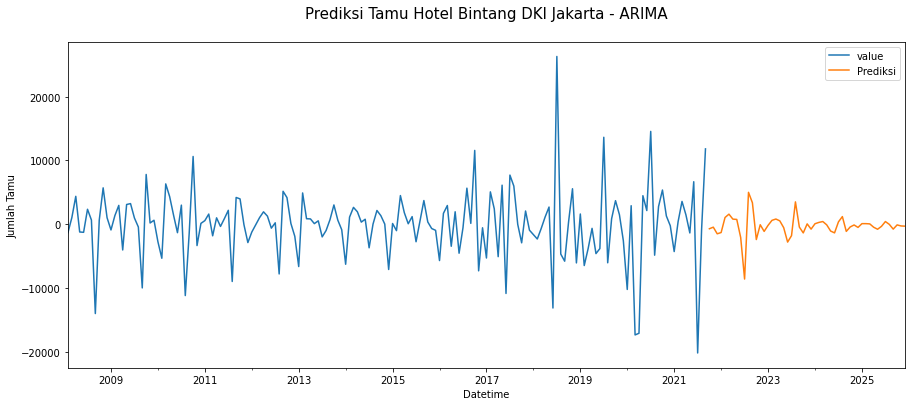

In [26]:
jak_stat.plot(legend=True, figsize=(15,6))
pred.plot(legend=True, label='Prediksi')
plt.title('Prediksi Tamu Hotel Bintang DKI Jakarta - ARIMA\n', size=15)
plt.xlabel('Datetime')
plt.ylabel('Jumlah Tamu')
plt.show()

Gambar diatas adalah grafik prediksi jumlah tamu untuk 50 bulan kedepan, namun perlu diingat data tersebut merupakan data yang telah di shift menggunakan fungsi diff(). maka kita perlu mengembalikanny lagi menjadi data semula untuk melihat nilai prediksi actualnya

In [27]:
# melakukan shift data -1
idx = pred.index.values

x = jakartadf.value
pred_tamu = []
lag = 1
for i, diff in enumerate(pred):
    prev_value = x[-(lag)+i:][0]
    pred_tamu.append(prev_value+diff)
    
tamu_forecast = pd.Series(pred_tamu, idx)
tamu_forecast

2021-10-01    41919.452195
2021-11-01    51835.191848
2021-12-01    49486.148053
2022-01-01    50732.755180
2022-02-01    57472.882924
2022-03-01    56785.509732
2022-04-01    54747.582093
2022-05-01    57047.717793
2022-06-01    54894.506003
2022-07-01    34370.495700
2022-08-01    48597.652296
2022-09-01    52669.875625
2022-10-01    47935.183879
2022-11-01    49366.154795
2022-12-01    49678.563601
2023-01-01    53588.498810
2023-02-01    50343.320123
2023-03-01    53651.558321
2023-04-01    56606.007490
2023-05-01    56512.246994
2023-06-01    53826.402730
2023-07-01    44854.839618
2023-08-01    57961.106211
2023-09-01    54212.364268
2023-10-01    53922.799729
2023-11-01    52610.847697
2023-12-01    46458.765733
2024-01-01    53632.982262
2024-02-01    58181.358900
2024-03-01    59748.488658
2024-04-01    57907.822919
2024-05-01    59936.019332
2024-06-01    48470.698309
2024-07-01    48789.053086
2024-08-01    60242.909207
2024-09-01    54580.747100
2024-10-01    55417.067281
2

Setelah nilai asli telah didapatkan, kita akan melakukan ploting prediksi 50 bulan kedepan

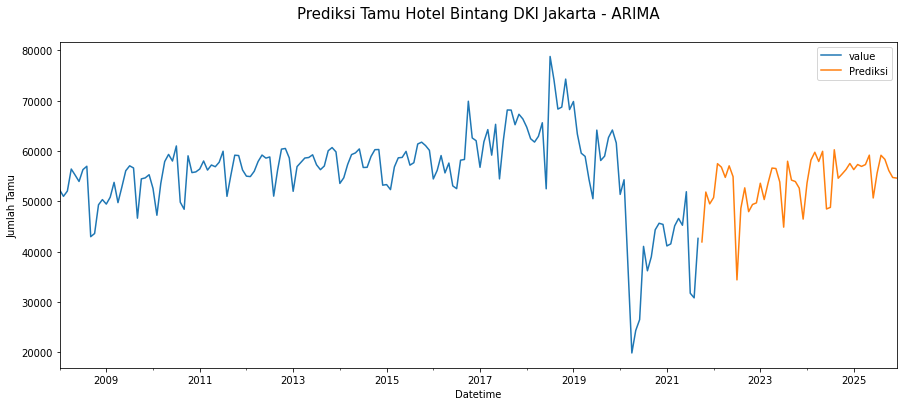

In [28]:
jakartadf.plot(legend=True, figsize=(15,6))
tamu_forecast.plot(legend=True, label='Prediksi')
plt.title('Prediksi Tamu Hotel Bintang DKI Jakarta - ARIMA\n', size=15)
plt.xlabel('Datetime')
plt.ylabel('Jumlah Tamu')
plt.show()

Seperti itulah hasil prediksi untuk data Jumlah Tamu Hotel Provinsi DKI Jakarta untuk 50 bulan kedepan (2021/10-2025/12)

Save model untuk proses deploy

In [29]:
# import pickle untuk save model
# import pickle

# filename = 'model.pkl'
# pickle.dump(model, open(filename, 'wb'))
print('model berhasil disimpan')

model berhasil disimpan
